# Assignment 4

**Deadline**: February 17, 9pm

**Late Penalty**: See Syllabus

**TA**: Hojjat Salehinejad

In this assignment, you will build and train an autoencoder for imputation of missing data. In the process, you will:

1. Clean and process continuous and categorical data for machine learning.
2. Understand and implement denoising autoencoders.
3. Tuning the hyperparameter setting of an autoencoder.

### What to submit

Submit a PDF file containing all your code and outputs. Do not submit any other files produced by your code.

Completing this assignment using Jupyter Notebook is recommended (though not necessarily for all subsequent assignments). If you are using Jupyter Notebook, you can export a PDF file using the menu option File -> Download As -> PDF via LaTeX (pdf)

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 
Installation instructions for `pandas` is available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

If you cannot get `pandas` installed, you may port the `pandas` code
we provided into `numpy` code.

In [2]:
import pandas as pd

# Part 1. Data Cleaning [12 pt]

The data set we will be using for this assignment is the 
Adult Data Set provided by UCI Machine Learning Repository [1] available 
at https://archive.ics.uci.edu/ml/datasets/adult.

Download the file `adult.data` from the website.

The data set contains census record files of adults, including their
age, type of work they do, martial status, etc. We will build a denoising
autoencoder on this dataset to impute (or "fill in") missing values
in the dataset.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### Part (a) Loading the Data [1 pt]

Use the function `pd.read_csv` to load the `adult.data` into a pandas
dataframe called `df`. Make sure that
the `adult.data` file is in the same folder as your notebook or python code.
Report the number of rows (records) in your data frame.

Note that the data file does **not** have an index column. The headers
of the file are given to you below. 

Hint: You will need to read a bit about the pandas documentation 
to do this problem https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']

df = pd.read_csv('adult.data', names = header,index_col = False)
rows = df.shape[0]
print('there are '+str(rows)+' rows in the data frame')

there are 32561 rows in the data frame


### Part (b) Continuous Features [1 pt]

For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], find the minimum, maximum, and average value across the dataset.

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 5 rows of the data frame (5 records) below:

In [4]:
df[:6]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [5]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [6]:
np.sum(subdf["caploss"])

2842700

### Part (c) Normalizing Continuous Features [1 pt]

Normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"]
so that their values are between 0 and 1. Just like numpy arrays, you can modify
data frames. For example, the code 

`df["age"] = df["age"] + 1` 

would increase everyone's age by 1.

In [7]:
for thing in ["age", "yredu", "capgain", "caploss", "workhr"]:
    df[thing] = (df[thing]-np.min(subdf[thing]))/(np.max(subdf[thing])-np.min(subdf[thing]))

### Part (d) Categorical Features [1 pt]

What percentage of people in our data set is male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set is female?

In [8]:
# hint: you can do something like this in pandas
percent_male = 100*sum(df["sex"] == " Male")/df.shape[0]
percent_female = 100*sum(df["sex"] == " Female")/df.shape[0]

print(str(percent_male)+"% of the people are male and "+str(percent_female)+"% of the people are female")

66.92054912318417% of the people are male and 33.07945087681582% of the people are female


### Part (e) Missing Values [1 pt]

We will do two things in this part:

1. We will restrict ourselves to a subset of the features
2. We will remove any records (rows) containing missing values, and store it in a second dataframe.

Both of these steps are done for you.

Report the number of records with and without missing features of interest.

In [9]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [10]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [11]:
print(str(df_with_missing.shape[0])+" of the records have missing features and "+str(df_not_missing.shape[0])+" do not")

1843 of the records have missing features and 30718 do not


### Part (f) One-Hot Encoding [1 pt]

What are all the possible values of "work" in `df_not_missing`? You may find the Python function `set` useful.

In [12]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

As discussed in class and in tutorial, we will be using a one-hot encoding 
to encode each of the categorical variables.

We will use the pandas function `get_dummies`:

In [13]:
data = pd.get_dummies(df_not_missing)

In [14]:
data[:5]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


### Part (g) One-Hot Encoding [1 pt]

How many columns are in the dataframe `data`?

Briefly explain where that number come from. (You don't need to be detailed here.)

In [15]:
#The possible values of each column of df_not_missing becomes a column in data, so there are more columns in data

### Part (h) One-Hot Conversion [3 pt]

We will convert the pandas data frame into numpy below.
However, in doing so, we lose the column information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will use this function on the output of our autoencoder,
to interpret our autoencoder outputs. So the input 
one-hot vectors might not actually be "one-hot".


In [16]:
datanp = data.values.astype(np.float32)

In [17]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of feature. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_onehot?(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    index = np.argmax(onehot)
    
    value = cat_values[feature][index]
    
    return value

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (i) Train/Test Split [2 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [18]:
np.random.seed(50) # set the numpy seed for consistent split

np.random.shuffle(datanp)

training = datanp[0:int(0.7*len(datanp))]
validation = datanp[int(0.7*len(datanp)):int(0.85*len(datanp))]
test = datanp[int(0.85*len(datanp)):len(datanp)]

print('training length:',len(training))
print('validation length:',len(validation))
print('test length:',len(test))

training length: 21502
validation length: 4608
test length: 4608


## Part 2. Model Setup [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`. 

There will be a sigmoid activation at the decoder, so that
the output of the decoder is between 0 and 1. We will not interpret 
the output of the sigmoid as a probability.

In [211]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 57),
            nn.ReLU(),
            nn.Linear(57, 30),
            nn.ReLU(),
#             nn.Linear(30, 10),
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(            
#             nn.Linear(10, 30),
#             nn.ReLU(),
            nn.Linear(30, 57),
#             nn.ReLU(),
#             nn.Linear(57, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder as follows:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, obtaining a reconstruction
- We will check how close the reconstruction is compared to the original data (without the missing feature)

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyways.)

In [212]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        
        total_train = 0
        total_val = 0
        
        for i, data in enumerate(train_loader):
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_train += loss.item()
        
        train_loss[epoch] = total_train/(i+1)
            
        for i, data in enumerate(val_loader):
            datam = zero_out_random_feature(data.detach().clone()) # zero out one categorical feature
            recon = model(datam).detach()
            loss = criterion(recon, data)
            
            total_val += loss.item()
            
        
        val_loss[epoch] = total_val/(i+1)
        
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)
        
    return train_loss, val_loss, train_acc, val_acc

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are less easy to compare
than accuracy percentages. The reason is that the scale of the loss value changes depending
on your batch size. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. You don't need to do anything else in this part. To earn the 4 marks,
plot the training and validation accuracy every few iterations/epochs as part of your
training curve.

In [213]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set
    
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             depending on your variable naming this code might not work
             out of the box)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run the training code, using reasonable settings like batch_size, learning rate, etc.

Include your training curve in your pdf output.

In [268]:
# train_loader = torch.utils.data.DataLoader(training, batch_size=256, shuffle=True)
# val_loader = torch.utils.data.DataLoader(validation, batch_size=256, shuffle=True)

# encoder1 = AutoEncoder()
# train_loss, val_loss, train_acc, val_acc = train(encoder1, train_loader, val_loader, 
#                                                  num_epochs=100, learning_rate=1e-4)

train_loader = torch.utils.data.DataLoader(training, batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation, batch_size=512, shuffle=True)

encoder1 = AutoEncoder()
train_loss, val_loss, train_acc, val_acc = train(encoder1, train_loader, val_loader, num_epochs=100, 
                                                 learning_rate=1e-3)

In [269]:
print(train_loss[:5], train_loss[-5:])
print(val_loss[:5], val_loss[-5:])
print()
print(train_acc[:5], train_acc[-5:])
print(val_acc[:5], val_acc[-5:])

[0.20214256 0.08225297 0.06882404 0.0616312  0.05504868] [0.01034095 0.00839321 0.00973644 0.0098613  0.01016131]
[0.12354041 0.07099974 0.06571766 0.05660254 0.05300146] [0.01293865 0.00839138 0.00869221 0.01056559 0.01139632]

[0.36805879 0.46034477 0.48538896 0.54401916 0.55103401] [0.65955105 0.65972158 0.64655226 0.65665209 0.65838837]
[0.36816406 0.46006944 0.48397714 0.54271557 0.55121528] [0.65657552 0.65614149 0.64416956 0.65418837 0.65483941]


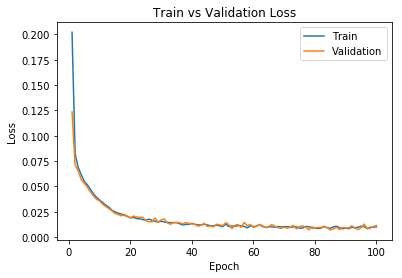

In [270]:
%matplotlib inline
import matplotlib.pyplot as plt

#train_loss = np.loadtxt("{}_train_loss.csv".format(path))
#val_loss = np.loadtxt("{}_val_loss.csv".format(path))
plt.show()
plt.title("Train vs Validation Loss")
plt.plot(range(1,len(train_loss)+1), train_loss, label="Train")
plt.plot(range(1,len(val_loss)+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

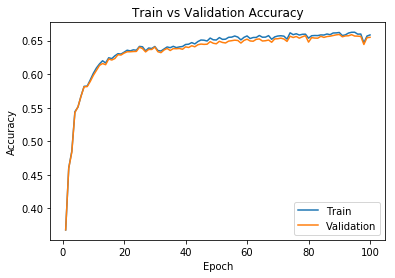

In [271]:
plt.show()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,len(train_acc)+1), train_acc, label="Train")
plt.plot(range(1,len(val_acc)+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models.

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

 -  I tried changing the batch size. I found that 
     -  with a lower batch size of 64, the accuracy became worse (the first batch size I had was 256)
     -  with a higher batch size 512, it got better
     -  with an even higher batch size of 1024, it did not improve
 - Changing the learning rate
     -  Increasing the learning rate from 0.0001 to 0.001 slighly improved the accuracy
     -  increasing to a higher learning rate 0.1 did not work
 - Tried changing the network architecture
     -  The model worked better when the encoded layer was larger. When I decreased the encoded layer to 5 and 10 nodes, the accuracy decreased. I think this is because larger layers can hold more information.
     -  Adding more layers did not seem to help
 - Overall, the hyperparameters appeared to be codependent. Changing one requires having to tune the others to get the best results
      

## Part 4. Testing [6 pt]

### Part (a) [1 pt]

Compute the test accuracy across the test set.

In [228]:
test_loader = torch.utils.data.DataLoader(test, batch_size=1024, shuffle=True)
test_acc = get_accuracy(encoder1, test_loader)
print(test_acc)

0.6351273148148148


### Part (b) [2 pt]

Consider an alterative, baseline model that predicts missing data as follows. To predict a missing feature, the
baseline model will look at the **most common value** of the feature in the training set. For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set.

What would be the test accuracy of this baseline model?

It is often helpful to use the performance of the baseline model to help judge how well our model is actually performing. No explanation is required in this question, just your calculations.

In [233]:
probability = 0

for thing in cat_values:
    probability += 1/len(cat_values[thing])
    
base_acc = probability/len(cat_values)

print(base_acc)

0.1810515873015873


### Part (c) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [249]:
xyz=test[0:1]
#
xyz = xyz.copy()
xyz
dfxyz = pd.DataFrame(xyz, columns=data.columns)
dfxyz.iloc[0]

age                                0.657534
yredu                              0.800000
capgain                            0.067231
caploss                            0.000000
workhr                             0.397959
work_ Federal-gov                  0.000000
work_ Local-gov                    0.000000
work_ Private                      1.000000
work_ Self-emp-inc                 0.000000
work_ Self-emp-not-inc             0.000000
work_ State-gov                    0.000000
work_ Without-pay                  0.000000
marriage_ Divorced                 1.000000
marriage_ Married-AF-spouse        0.000000
marriage_ Married-civ-spouse       0.000000
marriage_ Married-spouse-absent    0.000000
marriage_ Never-married            0.000000
marriage_ Separated                0.000000
marriage_ Widowed                  0.000000
occupation_ Adm-clerical           0.000000
occupation_ Armed-Forces           0.000000
occupation_ Craft-repair           0.000000
occupation_ Exec-managerial     

In [ ]:
# I think it would be possible to make a good guess about this person's education level
# based on information given about there work and occupation
# this person works for a private company and has a professional specialty occupation
# so this might lead someone to guess that they have their bachelors
# however other education levels would also be possible, so we would not be guaranteed to guess correctly

### Part (d) [2 pt]

What is your model's guess of this person's education
level, given their other features?


In [265]:
testrow = zero_out_feature(xyz, 'edu')
testrow_loader = torch.utils.data.DataLoader(testrow, batch_size=1)
for x in testrow_loader:
    out = encoder1(x)
    
get_feature(out.detach().numpy()[0], 'edu')


'Masters'

In [266]:
#its wrong